The goal of this notebook is to catagorize pitchers using k-means clustering (from scratch and with Scikit-learn) to see how the winners of the 2022 cy young winners compare to the groups they are assigned to. 

I followed Dataquest's video to help me with this project.

K-Means from scratch. 

In [234]:
# Importing libraries 
import numpy as np
import pandas as pd 
from pybaseball import pitching_stats
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt 
from IPython.display import clear_output

## 2022 CY Young Winners were Sandy Alcantara and Justin Verlander.



In [235]:
# Importing and cleaning data 
players = pitching_stats(2020, 2023)
players.sort_index(inplace=True)

Bauer_2020 = players.index[(players["Name"] == "Trevor Bauer") & (players["Season"] == 2020)].to_list()
Bieber_2020 = players.index[(players["Name"] == "Shane Bieber") & (players["Season"] == 2020)].to_list()

Burns_2021 = players.index[(players["Name"] == "Corbin Burnes") & (players["Season"] == 2021)].to_list()
Ray_2021 = players.index[(players["Name"] == "Robbie Ray") & (players["Season"] == 2021)].to_list()

Verlander_2022 = players.index[(players["Name"] == "Justin Verlander") & (players["Season"] == 2022)].to_list()
Alcantara_2022 = players.index[(players["Name"] == "Sandy Alcantara") & (players["Season"] == 2022)].to_list()

Snell_2023 = players.index[(players["Name"] == "Blake Snell") & (players["Season"] == 2023)].to_list()
Cole_2023 = players.index[(players["Name"] == "Gerrit Cole") & (players["Season"] == 2023)].to_list()


winners_ids = [Bauer_2020, Bieber_2020, Burns_2021, Ray_2021, Verlander_2022, Alcantara_2022, Snell_2023, Cole_2023]

print(winners_ids)

[[1], [0], [14], [33], [2], [10], [9], [22]]


In [236]:
features = ["ERA", 'WHIP', 'H', 'R', "HR", 'BB', 'HBP']
data = players[features].copy()

1. Scale the data
2. Initalize random centroids
3. Label each data point based on how far that data point is from each centroid (cluster assignment for each pitcher)
4. Update centroids
5. Repeat steps 3, 4 until centroids stop changing

In [237]:
data = ((data - data.min()) / (data.max() - data.min())) * 9 + 1
data.head

<bound method NDFrame.head of            ERA      WHIP         H          R         HR        BB  HBP
0     1.000000  2.317073  1.336898   1.000000   2.071429  2.369565  1.5
1     1.177165  1.439024  1.096257   1.156522   2.500000  1.978261  2.5
2     1.212598  1.878049  4.705882   3.191304   3.142857  3.152174  4.0
3     1.637795  4.731707  1.625668   1.000000   1.000000  1.978261  1.0
4     1.673228  3.304878  1.962567   1.234783   1.642857  1.684783  2.0
..         ...       ...       ...        ...        ...       ...  ...
163   7.679134  7.804878  2.058824   3.034783   2.500000  2.858696  2.5
164   8.263780  8.024390  8.219251   9.765217  10.000000  6.869565  5.5
165   8.423228  8.902439  8.363636   8.747826   8.500000  6.184783  2.5
166   9.238189  6.378049  7.593583  10.000000   8.928571  4.717391  4.0
167  10.000000  9.012195  2.347594   3.426087   3.785714  2.467391  3.5

[168 rows x 7 columns]>

In [238]:
data.describe()


,ERA,WHIP,H,R,HR,BB,HBP
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,4.433001,5.509146,5.747804,4.999224,4.558673,4.525233,4.050595
std,1.607208,1.701497,2.310071,2.019434,1.780074,1.756402,1.971838
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.303150,4.265244,4.705882,3.484783,3.142857,3.054348,2.500000
50%,4.215551,5.500000,6.606952,5.382609,4.642857,4.668478,4.000000
75%,5.455709,6.597561,7.352941,6.243478,5.714286,5.695652,5.500000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [239]:

# Iterate through each column in our data, then calls x.sample to select a single random value from that column and turns it into a float. 
# Next it appends these centroids into a list and when the loop is complete it it creates a dataframe out of them with each column being each centroid. 
def random_centroids(data, k):
    centroids = []
    for i in range(k):
        centroid = data.apply(lambda x: float(x.sample()))
        centroids.append(centroid)
    return pd.concat(centroids, axis = 1)





In [240]:
centroids = random_centroids(data, 4)
centroids

/var/folders/zh/rgqvb6zn45j1dm3h1gw654r00000gn/T/ipykernel_8751/839499929.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  centroid = data.apply(lambda x: float(x.sample()))


,0,1,2,3
ERA,4.312992,3.692913,3.870079,4.596457
WHIP,4.182927,6.268293,5.609756,4.731707
H,2.828877,8.171123,7.545455,4.994652
R,5.382609,4.991304,6.243478,2.565217
HR,3.571429,5.285714,4.857143,1.214286
BB,2.565217,2.271739,2.467391,2.369565
HBP,1.000000,3.000000,4.500000,4.000000


In [241]:
# Label each datapoint according to the cluster centers. 
# Looks at each player (data point) and finds the eculidian distance between the player and each centroid. 
# Next it finds the cluster center that is closest to that player. 

def get_labels(data, centroids):
    distances = centroids.apply(lambda x: np.sqrt(((data - x) **2).sum(axis=1)))
    return distances.idxmin(axis=1)



In [242]:
labels = get_labels(data, centroids)
labels.value_counts()

2    96
3    31
1    21
0    20
Name: count, dtype: int64

In [243]:
# Grouping data by labels. 
# Finding the geometric mean of each cluster.
def new_centroids(data, labels, k):
    return data.groupby(labels).apply(lambda x: np.exp(np.log(x)).mean()).T

In [244]:
def plot_clusters(data, labels, centroids, iterations): 
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    centroids_2d = pca.transform(centroids.T)
    clear_output(wait=True)
    plt.title(f'Iteration{iteration}')
    plt.scatter(x=data_2d[:,0], y=data_2d[:,1], c=labels, marker= "*")
    plt.scatter(x=centroids_2d[:,0], y=centroids_2d[:,1])
    plt.show()

In [ ]:
# Elbow Method 



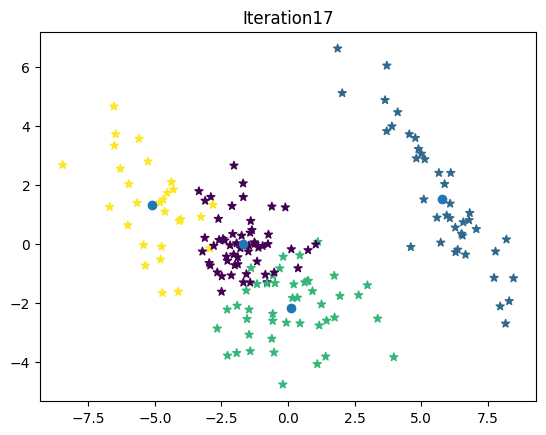

In [245]:
max_iterations = 100
k = 4

centroids = random_centroids(data, k)
old_centroids = pd.DataFrame()
iteration = 1 

while iteration < max_iterations and not centroids.equals(old_centroids): 
    old_centroids = centroids 

    labels = get_labels(data, centroids)
    centroids = new_centroids(data, labels, k)
    plot_clusters(data, labels, centroids, iteration)
    iteration += 1

In [246]:
centroids

,0,1,2,3
ERA,4.628669,4.259400,3.089370,6.456060
WHIP,5.539911,5.360061,4.300000,7.604965
H,7.092173,1.989037,6.118717,7.880634
R,5.995889,2.054565,4.779130,7.601863
HR,5.480519,2.360714,4.171429,6.510204
BB,4.882806,2.217935,5.141304,6.128882
HBP,3.809091,2.225000,5.033333,5.553571


In [247]:
for i in winners_ids: 
    print(labels[i])

1    1
dtype: int64
0    1
dtype: int64
14    2
dtype: int64
33    0
dtype: int64
2    2
dtype: int64
10    2
dtype: int64
9    2
dtype: int64
22    2
dtype: int64


My groups seem to jump around a lot everytime I run the algorithm. A few of things could be happening: My code not be working they way I think  it is, the Cy Young is not based on objective data, or k-means is not a good usecase for this question. 